In [1]:
import numpy as np
import math
import os
import sys
import joblib
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u
import astropy.coordinates 
from astropy import cosmology
from astropy.coordinates import Distance
from astropy import constants as const
from astropy.cosmology import wCDM
import random
import corner
from tqdm import tqdm
import emcee
import corner
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import scipy.stats as stats
from scipy.stats import multivariate_normal, uniform
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import skew
from scipy.integrate import quad
from scipy.optimize import minimize
import warnings
import getdist
from getdist import plots, MCSamples
import pandas as pd
from pandas import DataFrame


from IPython.display import display, Latex

warnings.filterwarnings("ignore")

# If you want to match the text literally without using regex special characters:
warnings.filterwarnings("ignore", message=r"fine_bins not large enough to well sample smoothing scale")

# If you actually need to use special regex characters like .* for any character repetition:
warnings.filterwarnings("ignore", message=r".*fine_bins not large enough to well sample smoothing scale.*")

cwd = os.getcwd()
base_path = cwd
print('Base directory path:', base_path)

Base directory path: /Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/compound_lens/compound_lens_dcls1507-NS-main/notebooks


In [2]:
savefig_path="/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL"

### functions for mcmc sampling

In [3]:
def single_variate_gaussian(x, mean, variance): 
    # Ensure x and mean are numpy arrays to support element-wise operations
    x = np.array(x)
    mean = np.array(mean)
    # Calculate the difference between x and the mean
    x_diff = x - mean    
    # Calculate the exponent in the Gaussian formula (using variance instead of covariance matrix)
    exponent = -0.5 * (x_diff ** 2) / variance   
    # Calculate the normalization constant for 1D Gaussian
    normalization = 1.0 / (np.sqrt(2 * np.pi * variance))   
    # Calculate the final Gaussian value
    gaussian_value = normalization * np.exp(exponent)    
    return gaussian_value


def log_prior(parameters):
    w0, omega_m = parameters
    omega_m_prior = 0. if 0.0 < omega_m < 1 else -np.inf
    w0_prior = 0. if -2 < w0 < 0 else -np.inf
    #omega_m_prior = 0. if 0.1 <= omega_m <= 0.5 else -np.inf
    #w0_prior = 0. if -1.2 <= w0 <= -0.8 else -np.inf
    return omega_m_prior + w0_prior


def log_likelihood(parameters):
    w0, omega_m = parameters
    cosmo = wCDM(H0=70, Om0=omega_m, Ode0=1-omega_m, w0=w0)  
    x1 = cosmo.angular_diameter_distance(z=z_l).value
    x2 = cosmo.angular_diameter_distance(z=z_s1).value
    x3 = cosmo.angular_diameter_distance(z=z_s2).value
    x12 = cosmo.angular_diameter_distance_z1z2(z1=z_l, z2=z_s1).value
    x13 = cosmo.angular_diameter_distance_z1z2(z1=z_l, z2=z_s2).value
    x23 = cosmo.angular_diameter_distance_z1z2(z1=z_s1, z2=z_s2).value
    predicted_a1 = x2*x13/(x3*x12)
    predicted_a2 = x2*x13/(x1*x23)
    array = [predicted_a1,predicted_a2]
    return array

def log_likelihood_a1(parameters, zlens, zsrc1, zsrc2):
    w0, omega_m = parameters
    cosmo = wCDM(H0=70, Om0=omega_m, Ode0=1-omega_m, w0=w0)  
    x1 = cosmo.angular_diameter_distance(z=zlens).value
    x2 = cosmo.angular_diameter_distance(z=zsrc1).value
    x3 = cosmo.angular_diameter_distance(z=zsrc2).value
    x12 = cosmo.angular_diameter_distance_z1z2(z1=zlens, z2=zsrc1).value
    x13 = cosmo.angular_diameter_distance_z1z2(z1=zlens, z2=zsrc2).value
    x23 = cosmo.angular_diameter_distance_z1z2(z1=zsrc1, z2=zsrc2).value
    predicted_a1 = x2*x13/(x3*x12)
    array = [predicted_a1]
    return array


def make_log_probability_a1(mean_values, variance, zl, zs1, zs2):
    zl=zl
    zs1=zs1
    zs2=zs2
    #print(zl,zs1,zs2)
    def log_probability(parameters):
        lp = log_prior(parameters)
        if not np.isfinite(lp):
            return -np.inf
        array = log_likelihood_a1(parameters,zl,zs1,zs2)
        #print('a1 array', array )
        gaussian_estimate = single_variate_gaussian(array, mean_values, variance)
        return lp + np.log(gaussian_estimate)
    print('function of parameters generated ')
    return log_probability

def log_prior_lcdm(parameter_Om):
    omega_m = parameter_Om
    omega_m_prior = 0. if 0.0 < omega_m < 1 else -np.inf
    #w0_prior = -1 #0. if -2 < w0 < 0 else -np.inf
    return omega_m_prior 

def log_likelihood_a1_lcdm(parameters_Om, zlens, zsrc1, zsrc2):
    omega_m = parameters_Om
    cosmo = wCDM(H0=70, Om0=omega_m, Ode0=1-omega_m, w0=-1)  
    x1 = cosmo.angular_diameter_distance(z=zlens).value
    x2 = cosmo.angular_diameter_distance(z=zsrc1).value
    x3 = cosmo.angular_diameter_distance(z=zsrc2).value
    x12 = cosmo.angular_diameter_distance_z1z2(z1=zlens, z2=zsrc1).value
    x13 = cosmo.angular_diameter_distance_z1z2(z1=zlens, z2=zsrc2).value
    x23 = cosmo.angular_diameter_distance_z1z2(z1=zsrc1, z2=zsrc2).value
    predicted_a1 = x2*x13/(x3*x12)
    array = [predicted_a1]
    return array


def make_log_probability_a1_lcdm(mean_values, variance, zl, zs1, zs2):
    zl=zl
    zs1=zs1
    zs2=zs2
    #print(zl,zs1,zs2)
    def log_probability(parameters_Om):
        lp = log_prior_lcdm(parameters_Om)
        if not np.isfinite(lp):
            return -np.inf
        array = log_likelihood_a1_lcdm(parameters_Om,zl,zs1,zs2)
        #print('a1 array', array )
        gaussian_estimate = single_variate_gaussian(array, mean_values, variance)
        return lp + np.log(gaussian_estimate)
    print('function of parameters generated ')
    return log_probability

In [4]:
#color blind friendly color cycle
CB_color_cycle = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

### assign measured/observed redshifts of lens and sources

In [5]:
# Given parameters
z_l = 0.594   # Redshift of the lens
z_s1 = 2.163  # Redshift of source 1
z_s2 =  2.591 # Redshift of source 2

#beta_ls1_obs = 0.9432453442218877 #1/1.060133
#err_beta_ls1_obs= (beta_ls1_obs*0.2/100) #1.1605807589426922e-05 

### compute distance ratio factors using fiducial cosmology (in this case LCDM)

#### see factors definition here https://github.com/lenstronomy/lenstronomy/discussions/558

In [6]:
cosmo = wCDM(H0=70, Om0=0.3, Ode0=0.7, w0=-1)  
d1 = cosmo.angular_diameter_distance(z=z_l).value
d2 = cosmo.angular_diameter_distance(z=z_s1).value
d3 = cosmo.angular_diameter_distance(z=z_s2).value
d12 = cosmo.angular_diameter_distance_z1z2(z1=z_l, z2=z_s1).value
d13 = cosmo.angular_diameter_distance_z1z2(z1=z_l, z2=z_s2).value
d23 = cosmo.angular_diameter_distance_z1z2(z1=z_s1, z2=z_s2).value
 
fiducial_a1 = d2*d13/(d3*d12)
fiducial_a2 = d2*d13/(d1*d23)

print('\n', f'fiducial a_1 : ', fiducial_a1, '\n', f'fiducial a_2 : ', fiducial_a2)
fiducial_dist_ratios = np.array([fiducial_a1, fiducial_a2])


 fiducial a_1 :  1.060132740055715 
 fiducial a_2 :  8.884610199571613


### Read in distance ratio factors obtained/observed from Lens model

In [7]:
job_name_out = 'DCLS1507_from_scratch_composite_double_source_11_run_07'  # DCLS1507_from_scratch_NFW_1_2_1_run_02
#cluster run
input_temp = os.path.join(base_path, 'midway_temp', job_name_out +'.txt')
output_temp = os.path.join(base_path, 'midway_temp', job_name_out +'_out.txt')
f = open(output_temp, 'rb')
[input_, output_] = joblib.load(f)
f.close()

fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

In [8]:
mcmc_out = [x for x in fit_output if x[0]=='emcee']
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = mcmc_out[0] #fit_output[2]
    
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)

n, num_param = np.shape(samples_mcmc)
print("number of evaluations in the MCMC process: ", n)


number of non-linear parameters in the MCMC process:  42
parameters in order:  ['Rs_lens0', 'alpha_Rs_lens0', 'e1_lens0', 'e2_lens0', 'gamma_ext_lens1', 'psi_ext_lens1', 'theta_E_lens2', 'theta_E_lens3', 'gamma_lens3', 'alpha_1_lens4', 'theta_E_lens5', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_source_light2', 'n_sersic_source_light2', 'e1_source_light2', 'e2_source_light2', 'center_x_source_light2', 'center_y_source_light2', 'w_c_lens_light0', 'w_t_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'n_sersic_lens_light1', 'center_x_lens_light1', 'center_y_lens_light1', 'R_sersic_lens_light2', 'n_sersic_lens_light2', 'e1_lens_light2', 'e2_lens_light2', 'center_x_lens_light2', 'center_y_lens_light2', 'factor_a_1', 'factor_a_2']
number of evaluations in the MCMC process:  1344000


### factor a_1 and a_2 corner plot and histogram

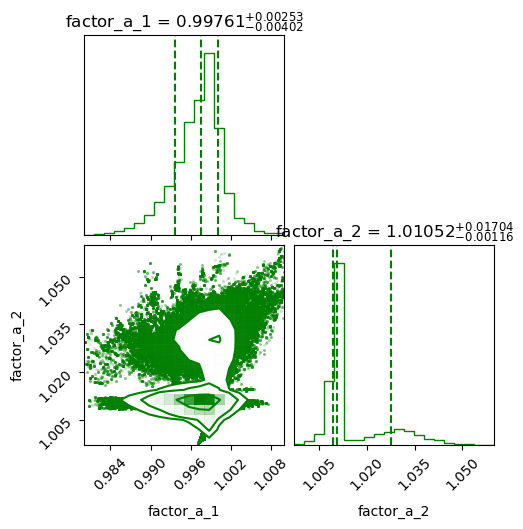

In [9]:
sample=samples_mcmc[:,40:42] #discarding first 500,000
col_name=param_mcmc[40:42]
figure = corner.corner(sample,color='green',
                       labels=col_name,
                       title_quantiles=[0.16, 0.5, 0.84],
                       title_fmt=".5f",
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True,
                       smooth=0.5                    
                       )

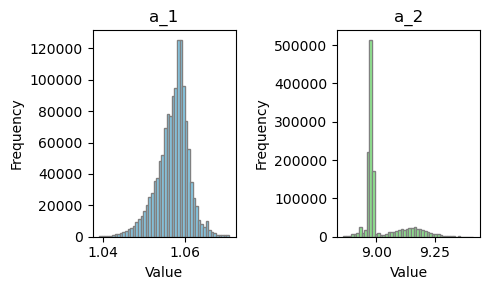

In [10]:
factor_a_1=samples_mcmc[:,40]
factor_a_2=samples_mcmc[:,41]

a_1=factor_a_1*fiducial_a1
a_2=factor_a_2*fiducial_a2

titles = [r'a_1', r'a_2']
fig, axs = plt.subplots(1, 2, figsize=(5, 3))

# Plot the distributions
axs[0].hist(a_1, bins=50, color='skyblue', edgecolor='gray')
axs[0].set_title(titles[0])

axs[1].hist(a_2, bins=50, color='lightgreen', edgecolor='gray')
axs[1].set_title(titles[1])

# Add some labels and adjust layout
for ax in axs.flat:
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## mcmc sampling

### obtain log probability density function of the observed distance ratio factors

#### using only a1 (i.e. 1/beta) because a2 s degenerate with a1

In [11]:
a1_samples=np.array([a_1] ) # two row and n columns
print(a1_samples)
# obtain  mean_values_initial and cov_matrices for the observed combined samples
mean_a1_samples = np.mean(a1_samples) #mean of n values 
print(mean_a1_samples)
variance_a1_samples = np.var(a1_samples) #, rowvar=False
print(variance_a1_samples)

# Create the log_probability function for the observed combined samples
log_prob_function_a1 = make_log_probability_a1(mean_a1_samples, variance_a1_samples, z_l, z_s1, z_s2)
print(log_prob_function_a1)

[[1.05593371 1.05934356 1.05983499 ... 1.06013463 1.04865536 1.055674  ]]
1.0569937161115737
1.5407114526047645e-05
function of parameters generated 
<function make_log_probability_a1.<locals>.log_probability at 0x7f9ad14fcaf0>


In [12]:
beta_samples=1/a1_samples
beta_median=np.median(beta_samples)
print(beta_median)
err_beta_lower = beta_median - np.percentile(beta_samples, 16)
print(err_beta_lower)
err_beta_upper = np.percentile(beta_samples, 84) - beta_median
print(err_beta_upper)
display(Latex(f'Median values: $\\beta_{{12}} = {beta_median:.3f}_{{-{err_beta_lower:.3f}}}^{{+{err_beta_upper:.3f}}}$'))

#err_beta=np.sqrt(np.abs(-variance_a1_samples/mean_a1_samples**2))
#print(err_beta)

0.9455417548805001
0.0023943765666100125
0.0038261747060851503


<IPython.core.display.Latex object>

### set up mcmc

In [13]:
# Set up the MCMC sampler
n_walkers =200 #200  # Fixed number of walkers
n_steps_mcmc =1000  #1000 # Number of steps per walker
n_dim = 2  # Number of dimensions (Omega_m and w0)

'''
# Mean values
mean_w0 = -1.0
mean_omega_m = 0.3
# Standard deviations to achieve the desired range
std_w0 = 0.3  # 0.1 To span -1.2 to -0.8 within two standard deviation
std_omega_m = 0.15  # 0.1 To span 0.1 to 0.5 within two standard deviation

# Construct the mean vector and covariance matrix
mean_w0_Om = np.array([mean_w0, mean_omega_m])
cov_matrix_w0_Om = np.array([[std_w0**2, 0], [0, std_omega_m**2]]) #no correlation between w0, omega_m

# Initialize the walkers initial position using a Gaussian distribution
pos = np.random.multivariate_normal(mean_w0_Om, cov_matrix_w0_Om, size=n_walkers)
'''

# Set the  prior bounds, in this case uniform
w0_min, w0_max = -2, 0  # Bounds for w0
omega_m_min, omega_m_max = 0, 1  # Bounds for Omega_m

pos = np.random.uniform(low=[w0_min, omega_m_min], high=[w0_max, omega_m_max], size=(n_walkers, n_dim))

# Set up the sampler
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob_function_a1)


### run mcmc to constrain w0 and Omega_m using observed distance ratio pdfs

In [15]:
# Run the MCMC sampler
sampler.run_mcmc(pos, n_steps_mcmc, progress=True) #
print("mcmc ran successfully !!")

samples = sampler.get_chain(flat=True) #samples in 2D shape = (n_steps * n_walkers, n_params)
np.save(f'mcmc_samples_wCDM_{job_name_out}.npy', samples)

100%|███████████████████████████████████████| 1000/1000 [02:45<00:00,  6.05it/s]

mcmc ran successfully !!


### Analyse mcmc results

In [14]:
# Retrieve the MCMC samples
#samples = sampler.get_chain(flat=True)

#OR
#Load from saved mcmc chain
samples=np.load('mcmc_samples_wCDM_DCLS1507_from_scratch_composite_double_source_11_run_07.npy')

# Calculate median values and uncertainties
median_w0_model = np.median(samples[:, 0])
lower_w0, upper_w0 = np.percentile(samples[:, 0], [16, 84])
median_Omega_m_model = np.median(samples[:, 1])
lower_Omega_m, upper_Omega_m = np.percentile(samples[:, 1], [16, 84])

print(f"Completed MCMC for {job_name_out}")

# Display the median values with uncertainties
display(Latex(f'Median values: $\Omega_m = {median_Omega_m_model:.2f}_{{-{median_Omega_m_model - lower_Omega_m:.2f}}}^{{+{upper_Omega_m - median_Omega_m_model:.2f}}}$'))
display(Latex(f'Median values: $w = {median_w0_model:.2f}_{{-{median_w0_model - lower_w0:.2f}}}^{{+{upper_w0 - median_w0_model:.2f}}}$'))

Completed MCMC for DCLS1507_from_scratch_composite_double_source_11_run_07


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### plot mcmc chain

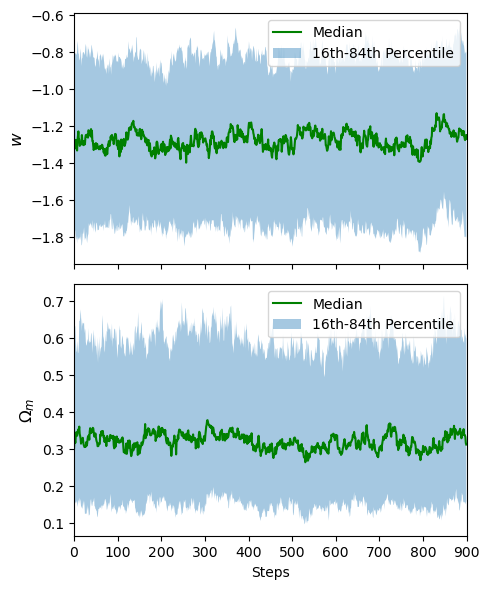

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [15]:
# Extract the MCMC samples and remove the burn-in phase
burn_in_steps = 100 # Set this if you want to remove some steps as burn-in

#mcmc_samples = sampler.get_chain(flat=True)[burn_in_steps * n_walkers:] #remove burnin steps
#mcmc_samples=sampler.get_chain(flat=True)

mcmc_samples=samples[burn_in_steps * n_walkers:]
mcmc_samples_3d = samples.reshape((n_steps_mcmc, n_walkers, -1))
#mcmc_samples=samples

# Check if there are any samples
if mcmc_samples.size > 0:
    # Determine the number of parameters and steps
    n_params = mcmc_samples.shape[1]
    chain = mcmc_samples_3d #sampler.get_chain()   ## 3D Shape: (n_steps_mcmc, n_walkers, n_params)
    chain = chain[burn_in_steps:]  # Discard burn-in if any
    n_steps = chain.shape[0]

    # Initialize arrays to store statistics
    mean_pos = np.zeros((n_params, n_steps))
    median_pos = np.zeros((n_params, n_steps))
    std_pos = np.zeros((n_params, n_steps))
    q16_pos = np.zeros((n_params, n_steps))
    q84_pos = np.zeros((n_params, n_steps))

    # Calculate statistics for each parameter at each step
    for i in range(n_params):
        for j in range(n_steps):
            mean_pos[i][j] = np.mean(chain[j, :, i])
            median_pos[i][j] = np.median(chain[j, :, i])
            std_pos[i][j] = np.std(chain[j, :, i])
            q16_pos[i][j] = np.percentile(chain[j, :, i], 16.)
            q84_pos[i][j] = np.percentile(chain[j, :, i], 84.)

    # Plotting the chains with median, and 16th-84th percentiles
    fig, ax = plt.subplots(n_params, sharex=True, figsize=(12, 6))
    param_names = [r"$w$", r"$\Omega_m$"]  # Adjust this if you have different parameters
    for i in range(n_params):
        ax[i].plot(median_pos[i], c='g', label='Median')
        ax[i].fill_between(np.arange(n_steps), q16_pos[i], q84_pos[i], alpha=0.4, label='16th-84th Percentile')
        ax[i].set_ylabel(param_names[i], fontsize=12)
        ax[i].legend()

    ax[-1].set_xlim(0, n_steps)
    ax[-1].set_xlabel('Steps')
    fig.set_size_inches((5, 3 * n_params)) #12., 5 * n_params
    plt.tight_layout()
    plt.show()


# Calculate median values and 68% bounds

median_w0_model = np.median(samples[:, 0])
lower_w0, upper_w0 = np.percentile(samples[:, 0], [16, 84])
median_Omega_m_model = np.median(samples[:, 1])
lower_Omega_m, upper_Omega_m = np.percentile(samples[:, 1], [16, 84])

# Display the median values with uncertainties
display(Latex(f'Median values: $\Omega_m = {median_Omega_m_model:.2f}_{{-{median_Omega_m_model - lower_Omega_m:.2f}}}^{{+{upper_Omega_m - median_Omega_m_model:.2f}}}$'))
display(Latex(f'Median values: $w = {median_w0_model:.2f}_{{-{median_w0_model - lower_w0:.2f}}}^{{+{upper_w0 - median_w0_model:.2f}}}$'))


### Lambda CDM Omega_m value

### mcmc

In [16]:

log_prob_function_a1_lcdm = make_log_probability_a1_lcdm(mean_a1_samples, variance_a1_samples, z_l, z_s1, z_s2)
n_dim_lcdm=1 #only sampling Omega_m

#mean_0m=np.array([mean_omega_m])
#var_mean_0m=np.array([std_omega_m**2])
#pos_lcdm = np.random.normal(mean_0m, var_mean_0m, size=(n_walkers, n_dim_lcdm))

pos_lcdm = np.random.uniform(low=[omega_m_min], high=[omega_m_max], size=(n_walkers, n_dim_lcdm))
print(np.shape(pos_lcdm))

sampler_lcdm = emcee.EnsembleSampler(n_walkers, n_dim_lcdm, log_prob_function_a1_lcdm)
print(sampler_lcdm)

function of parameters generated 
(200, 1)


In [17]:
sampler_lcdm.run_mcmc(pos_lcdm, n_steps_mcmc, progress=True) #
print("mcmc ran successfully !!")

mcmc_samples_lcdm = sampler_lcdm.get_chain(flat=True)
np.save(f'mcmc_samples_LCDM_{job_name_out}.npy', mcmc_samples_lcdm)

  1%|▌                                        | 14/1000 [00:02<03:01,  5.44it/s]Traceback (most recent call last):
  File "/Users/nandinisahu/opt/anaconda3/envs/py3/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_20842/1003394135.py", line 98, in log_probability
    array = log_likelihood_a1_lcdm(parameters_Om,zl,zs1,zs2)
  File "/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_20842/1003394135.py", line 82, in log_likelihood_a1_lcdm
    x13 = cosmo.angular_diameter_distance_z1z2(z1=zlens, z2=zsrc2).value
  File "/Users/nandinisahu/opt/anaconda3/envs/py3/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py", line 1231, in angular_diameter_distance_z1z2
    return self._comoving_transverse_distance_z1z2(z1, z2) / (z2 + 1.0)
  File "/Users/nandinisahu/opt/anaconda3/envs/py3/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py", 

emcee: Exception while calling your likelihood function:
  params: [0.31237182]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

### plot mcmc

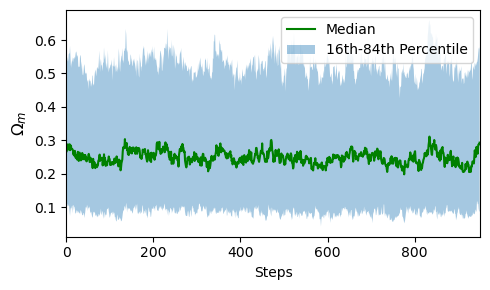

<IPython.core.display.Latex object>

In [18]:
# Extract the MCMC samples and remove the burn-in phase
burn_in_steps_lcdm = 50  # Set this if you want to remove some steps as burn-in

samples_lcdm=np.load('mcmc_samples_LCDM_DCLS1507_from_scratch_composite_double_source_11_run_07.npy')

#mcmc_samples_lcdm = sampler_lcdm.get_chain(flat=True)[burn_in_steps_lcdm * n_walkers:]
mcmc_samples_lcdm=samples_lcdm[burn_in_steps_lcdm * n_walkers:]
mcmc_samples_lcdm_3d = samples_lcdm.reshape((n_steps_mcmc, n_walkers, -1))

# Check if there are any samples
if mcmc_samples_lcdm.size > 0:
    # Determine the number of parameters and steps
    n_params = 1  # Since n_params is fixed to 1
    chain = mcmc_samples_lcdm_3d  #sampler_lcdm.get_chain()  # Shape: (n_steps_mcmc, n_walkers, n_params)
    chain = chain[burn_in_steps_lcdm:]  # Discard burn-in if any
    n_steps = chain.shape[0]

    # Initialize arrays to store statistics
    mean_pos = np.zeros((n_steps,))
    median_pos = np.zeros((n_steps,))
    std_pos = np.zeros((n_steps,))
    q16_pos = np.zeros((n_steps,))
    q84_pos = np.zeros((n_steps,))

    # Calculate statistics for the parameter at each step
    for j in range(n_steps):
        mean_pos[j] = np.mean(chain[j, :, 0])
        median_pos[j] = np.median(chain[j, :, 0])
        std_pos[j] = np.std(chain[j, :, 0])
        q16_pos[j] = np.percentile(chain[j, :, 0], 16.)
        q84_pos[j] = np.percentile(chain[j, :, 0], 84.)

    # Plotting the chain with median, and 16th-84th percentiles
    fig, ax = plt.subplots(figsize=(12, 6))  # Only one parameter, so no subplots
    param_name = r"$\Omega_m$"  # Adjust this if you have a different parameter

    ax.plot(median_pos, c='g', label='Median')
    ax.fill_between(np.arange(n_steps), q16_pos, q84_pos, alpha=0.4, label='16th-84th Percentile')
    ax.set_ylabel(param_name, fontsize=12)
    ax.legend()

    ax.set_xlim(0, n_steps)
    ax.set_xlabel('Steps')
    fig.set_size_inches((5, 3))  # Adjust the figure size for one parameter
    plt.tight_layout()
    plt.show()

# save_path = f'{base_file_path2}{model}/mcmc_chain_plot.jpg'
# fig.savefig(save_path, dpi=300)

# Calculate median values and uncertainties
median_Omega_m_lcdm = np.median(mcmc_samples_lcdm)
lower_Omega_m_lcdm, upper_Omega_m_lcdm = np.percentile(mcmc_samples_lcdm, [16, 84])

# Display the median values with uncertainties
display(Latex(f'Median values: $\Omega_m = {median_Omega_m_lcdm:.3f}_{{-{median_Omega_m_lcdm - lower_Omega_m_lcdm:.3f}}}^{{+{upper_Omega_m_lcdm - median_Omega_m_lcdm:.3f}}}$'))


### Probability Distribution function using Omega_m sample

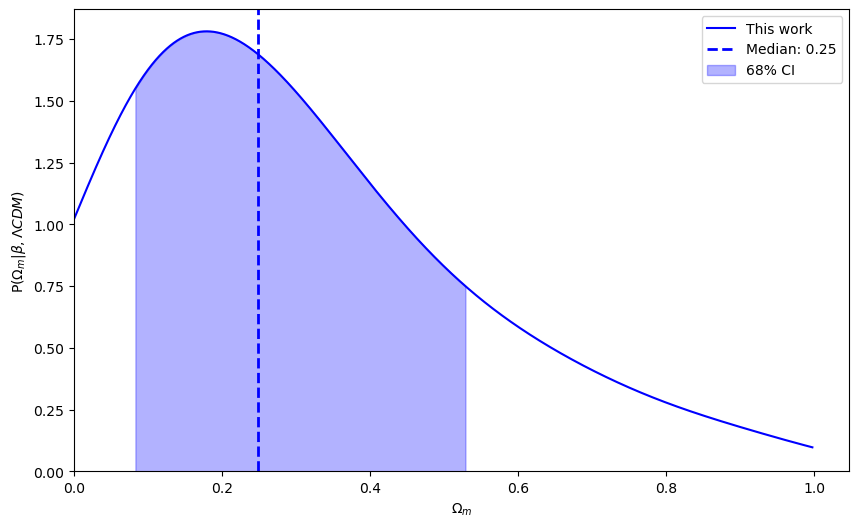

In [19]:
# Downsample the MCMC samples if too large (example: use 5000 random samples)
#mcmc_samples_lcdm_short=[]

n_samples = len(mcmc_samples_lcdm)

mcmc_samples_lcdm_kde=mcmc_samples_lcdm
if n_samples > 5000:
    mcmc_samples_lcdm_kde = np.random.choice(mcmc_samples_lcdm_kde.flatten(), 5000, replace=False)


x_val = np.linspace(min(mcmc_samples_lcdm_kde), max(mcmc_samples_lcdm_kde), 2000)

#bw_method: The method used to calculate the estimator bandwidth.  This can be 'scott', 'silverman', a scalar constant or a callable
kde_this_work= gaussian_kde(mcmc_samples_lcdm_kde, bw_method=0.5) #bw_method=0.2

pdf_this_work=kde_this_work(x_val)

# Create the plot
plt.figure(figsize=(10, 6))
# Add labels and title
# Plot each individual PDF
plt.plot(x_val, pdf_this_work, label='This work', color='blue')
#plt.plot(lcdm_median_Om*np.ones(5),np.linspace(0,1.82,5),color='blue')
plt.axvline(x=median_Omega_m_lcdm, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_Omega_m_lcdm:.2f}')

# Fill the 68% confidence interval under each PDF
plt.fill_between(x_val, pdf_this_work, where=(x_val >= lower_Omega_m_lcdm) &
                 (x_val <= upper_Omega_m_lcdm), 
                 color='blue', alpha=0.3, label='68% CI') #'68% CI (This work)'
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"P$(\Omega_m | \beta, \Lambda CDM)$")
#plt.title('Probability Distribution Plot')

# Change axis limits to include origin (0,0)
plt.xlim(left=0)  # Adjust the left limit of x-axis as needed
plt.ylim(bottom=0)  # Adjust the bottom limit of y-axis as needed
plt.legend()
#plt.savefig('/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/Om_PDF_LCDM_1507.pdf', dpi=1200)

plt.savefig( f'{savefig_path}/Om_PDF_LCDM_1507.pdf',  dpi=1200)

plt.show()


#### To extract LCDM Omega_m from the wo--omega_m 2D distribution (first mcmc chain)

In [20]:
def calculate_median_and_spread(w_values, Om_values, target_w_value=-1, tol=1e-4):
    # Convert to numpy arrays if they are not already
    Om_values = np.array(Om_values)
    w_values = np.array(w_values)
    
    # Use a tolerance for matching
    mask = np.abs(w_values - target_w_value) < tol
    # Apply the additional conditions Om > min_Om_value and Om < max_Om_value
    filtered_Om_values = Om_values[mask]
    
    # Calculate median and 68% confidence interval
    median_Om = np.median(filtered_Om_values) if len(filtered_Om_values) > 0 else np.nan    
    lower_median_Om, upper_median_Om = np.percentile(filtered_Om_values, [16, 84]) if len(filtered_Om_values) > 0 else np.nan
    
    # Calculate mean and standard deviation
    
    mean_Om = np.mean(filtered_Om_values) if len(filtered_Om_values) > 0 else np.nan
    std_Om = np.std(filtered_Om_values) if len(filtered_Om_values) > 0 else np.nan  
    
    return mean_Om, std_Om, median_Om, lower_median_Om, upper_median_Om, filtered_Om_values


####  w and Omega_m 2D  Distribution plots

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

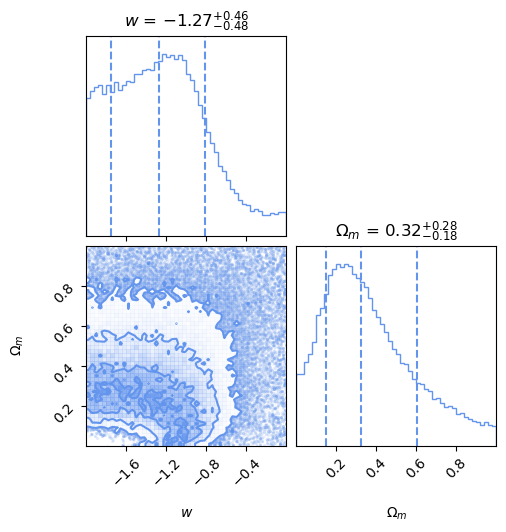

In [21]:
# Calculate median values
median_value_omega_m = np.median(samples[:, 1])
lower_Omega_m, upper_Omega_m = np.percentile(samples[:, 1], [16, 84]) #[16, 84] #
median_value_w0 = np.median(samples[:, 0])
lower_w0, upper_w0 = np.percentile(samples[:, 0], [16, 84])

# Display the median values with uncertainties
display(Latex(f'Median values: $\\Omega_m = {median_value_omega_m:.2f}_{{-{median_value_omega_m - lower_Omega_m:.2f}}}^{{+{upper_Omega_m - median_value_omega_m:.2f}}}$'))
display(Latex(f'Median values: $w = {median_value_w0:.2f}_{{-{median_value_w0 - lower_w0:.2f}}}^{{+{upper_w0 - median_value_w0:.2f}}}$'))

# Corner plot
fig = plt.figure(figsize=(10, 10))
corner.corner(samples, 
                labels=[r"$w$", r"$\Omega_m$"], 
                show_titles=True,
                plot_contours=True,
                bins=50,
               quantiles=[0.16, 0.5, 0.84], 
                color='cornflowerblue')
# save_path_corner = 'final_posterior_v1'
# plt.savefig(save_path_corner, dpi=250, bbox_inches='tight')
plt.close(fig)

Removed no burn in


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

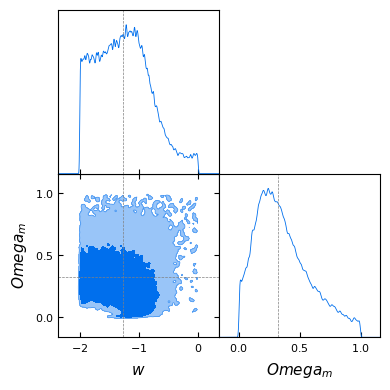

In [22]:
# Triangle plot using GetDist
param_names = ['w', 'omega_m']

gdsamples = MCSamples(samples=samples, names=param_names,labels=['w', 'Omega_m']) #, labels=[r"$w$", r"$\Omega_m$"] ,labels=['w', 'Omega_m']

g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))
range_limits = {'w': [-2.0, 0], 'omega_m': [0., 1]}  # Modify these ranges as needed

g.triangle_plot([gdsamples], filled=True, 
                markers={'w': median_value_w0, 'omega_m': median_value_omega_m},
                contour_args={'alpha': 1.},
                limits=range_limits
               )  # Apply range limits here

plt.close(fig)

# Display the median values with uncertainties
display(Latex(f'Median values: $\\Omega_m = {median_value_omega_m:.2f}_{{-{median_value_omega_m - lower_Omega_m:.2f}}}^{{+{upper_Omega_m - median_value_omega_m:.2f}}}$'))
display(Latex(f'Median values: $w = {median_value_w0:.2f}_{{-{median_value_w0 - lower_w0:.2f}}}^{{+{upper_w0 - median_value_w0:.2f}}}$'))

### checking skewness of Om and wo distributions

In [23]:
Om_sample=samples[:, 1]
# Fit the skewed normal distribution to data
alpha_hat, loc, scale = skewnorm.fit(Om_sample)
# Estimated parameters
print(f"Estimated skewness (alpha): {alpha_hat}")
print(f"Estimated location (mean): {loc}")
print(f"Estimated scale (std dev): {scale}")

#Positive skewness indicates right (positive) skew (meaning peak will be in the leftleft)
skewness = skew(Om_sample) #skewness coefficient.
print(f"Skewness of the data: {skewness}")

Estimated skewness (alpha): 6.081935681524466
Estimated location (mean): 0.07168129458361813
Estimated scale (std dev): 0.3696566482464021
Skewness of the data: 0.7107839939890781


In [24]:
w0_sample=samples[:, 0]
# Fit the skewed normal distribution to data
alpha_hat1, loc1, scale1 = skewnorm.fit(w0_sample)
# Estimated parameters
print(f"Estimated skewness (alpha): {alpha_hat1}")
print(f"Estimated location (mean): {loc1}")
print(f"Estimated scale (std dev): {scale1}")

#Positive skewness indicates right (positive) skew (meaning peak will be in the leftleft)
skewness1 = skew(w0_sample) #skewness coefficient.
print(f"Skewness of the data: {skewness1}")

Estimated skewness (alpha): 110.2615156779303
Estimated location (mean): -1.9929690211705475
Estimated scale (std dev): 0.8621013845684813
Skewness of the data: 0.40381111689697596


# Collett et al. 2014

### Beta_12 from Collett et al. 2014

In [25]:
beta_collett=0.712 
uncer_beta_collett=0.008
a1_collett=1/0.712 
print('a1_collett',a1_collett)
uncer_a1_collett=abs(- 0.008/(0.712**2)) 
print('uncer_a1_collett',uncer_a1_collett)
var_a1_collett=uncer_a1_collett**2
print('var_a1_collett',var_a1_collett)
z_l_jackpot = 0.222
z_s1_jackpot = 0.609
z_s2_jackpot = 2.035 #new redshift  (Collett+2014 old redshift z_s2= 2.35 )

a1_collett 1.404494382022472
uncer_a1_collett 0.015780835753061485
var_a1_collett 0.00024903477706510364


In [147]:
# Create the log_probability function for the observed combined samples
log_prob_a1_collett = make_log_probability_a1(a1_collett, var_a1_collett, z_l_jackpot, z_s1_jackpot, z_s2_jackpot)
print(log_prob_a1_collett)

# Set up the sampler
sampler_collett = emcee.EnsembleSampler(n_walkers, n_dim, log_prob_a1_collett)
# Run the MCMC sampler
pos1=pos  # same as our 2D mcmc run
sampler_collett.run_mcmc(pos1, n_steps_mcmc, progress=True) #
print("mcmc ran successfully !!")


mcmc_samples_collett = sampler_collett.get_chain(flat=True)
np.save('mcmc_samples_collett_wCDM.npy', mcmc_samples_collett)

function of parameters generated 
<function make_log_probability_a1.<locals>.log_probability at 0x7fccc66e2a70>


100%|███████████████████████████████████████| 1000/1000 [02:43<00:00,  6.11it/s]


mcmc ran successfully !!


### plot mcmc 

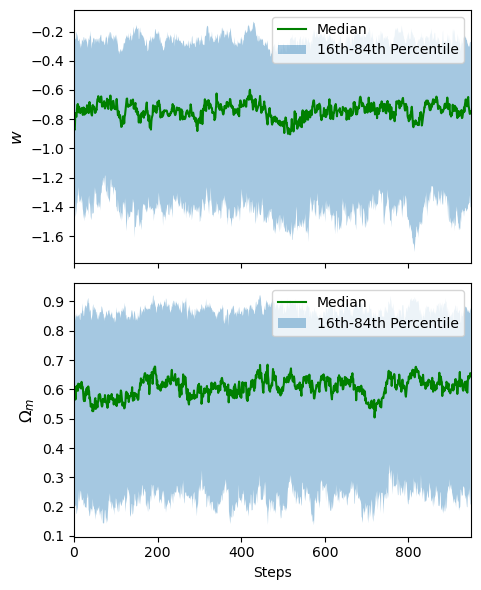

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [26]:
# Extract the MCMC samples and remove the burn-in phase
burn_in_steps = 50 # Set this if you want to remove some steps as burn-in

#mcmc_samples_collett = sampler_collett.get_chain(flat=True)[burn_in_steps * n_walkers:]

#Or load saved samples
samples_collett=np.load('mcmc_samples_collett_wCDM_new_z_s2.npy')

#mcmc_samples_lcdm = sampler_lcdm.get_chain(flat=True)[burn_in_steps_lcdm * n_walkers:]
mcmc_samples_collett=samples_collett[burn_in_steps_lcdm * n_walkers:]
mcmc_samples_collett_3d = samples_collett.reshape((n_steps_mcmc, n_walkers, -1))

# Check if there are any samples
if mcmc_samples_collett.size > 0:
    # Determine the number of parameters and steps
    n_params = mcmc_samples_collett.shape[1]
    chain2 = mcmc_samples_collett_3d #sampler_collett.get_chain()  # Shape: (n_steps_mcmc, n_walkers, n_params)
    chain2 = chain2[burn_in_steps:]  # Discard burn-in if any
    n_steps = chain2.shape[0]

    # Initialize arrays to store statistics
    mean_pos_collett  = np.zeros((n_params, n_steps))
    median_pos_collett  = np.zeros((n_params, n_steps))
    std_pos_collett  = np.zeros((n_params, n_steps))
    q16_pos_collett  = np.zeros((n_params, n_steps))
    q84_pos_collett  = np.zeros((n_params, n_steps))

    # Calculate statistics for each parameter at each step
    for i in range(n_params):
        for j in range(n_steps):
            mean_pos_collett[i][j] = np.mean(chain2[j, :, i])
            median_pos_collett[i][j] = np.median(chain2[j, :, i])
            std_pos_collett[i][j] = np.std(chain2[j, :, i])
            q16_pos_collett[i][j] = np.percentile(chain2[j, :, i], 16.)
            q84_pos_collett[i][j] = np.percentile(chain2[j, :, i], 84.)

    # Plotting the chains with median, and 16th-84th percentiles
    fig, ax = plt.subplots(n_params, sharex=True, figsize=(12, 6))
    param_names = [r"$w$", r"$\Omega_m$"]  # Adjust this if you have different parameters
    for i in range(n_params):
        ax[i].plot(median_pos_collett[i], c='g', label='Median')
        ax[i].fill_between(np.arange(n_steps), q16_pos_collett[i], q84_pos_collett[i], alpha=0.4, label='16th-84th Percentile')
        ax[i].set_ylabel(param_names[i], fontsize=12)
        ax[i].legend()

    ax[-1].set_xlim(0, n_steps)
    ax[-1].set_xlabel('Steps')
    fig.set_size_inches((5, 3 * n_params)) #12., 5 * n_params
    plt.tight_layout()
    plt.show()

# Calculate median values and bounds
median_w0_model_collett = np.median(mcmc_samples_collett[:, 0])
lower_w0_collett, upper_w0_collett = np.percentile(mcmc_samples_collett[:, 0], [16, 84])
median_Omega_m_model_collett = np.median(mcmc_samples_collett[:, 1])
lower_Omega_m_collett, upper_Omega_m_collett = np.percentile(mcmc_samples_collett[:, 1], [16, 84])

# Display the median values with uncertainties
display(Latex(f'Median values: $\Omega_m = {median_Omega_m_model_collett:.3f}_{{-{median_Omega_m_model_collett - lower_Omega_m_collett:.3f}}}^{{+{upper_Omega_m_collett - median_Omega_m_model_collett:.3f}}}$'))
display(Latex(f'Median values: $w = {median_w0_model_collett:.3f}_{{-{median_w0_model_collett - lower_w0:.3f}}}^{{+{upper_w0_collett - median_w0_model_collett:.3f}}}$'))


### LamdaCDM case for jacpot lens

#### run mcmc

In [29]:
log_prob_function_a1_lcdm_collett = make_log_probability_a1_lcdm(a1_collett, var_a1_collett, z_l_jackpot, z_s1_jackpot, z_s2_jackpot)
n_dim_lcdm=1 #only sampling Omega_m

#mean_0m=np.array([mean_omega_m])
#var_mean_0m=np.array([std_omega_m**2])
#pos_lcdm = np.random.normal(mean_0m, var_mean_0m, size=(n_walkers, n_dim_lcdm))

#pos_lcdm = np.random.uniform(low=[omega_m_min], high=[omega_m_max], size=(n_walkers, n_dim_lcdm))
#print(np.shape(pos_lcdm))

sampler_lcdm_collett  = emcee.EnsembleSampler(n_walkers, n_dim_lcdm, log_prob_function_a1_lcdm_collett)
print(sampler_lcdm_collett )


sampler_lcdm_collett.run_mcmc(pos_lcdm, n_steps_mcmc, progress=True) #
print("mcmc ran successfully !!")

mcmc_samples_lcdm_collett = sampler_lcdm_collett.get_chain(flat=True)
np.save(f'mcmc_samples_LCDM_collett.npy', mcmc_samples_lcdm_collett)

function of parameters generated 


  1%|▌                                        | 13/1000 [00:02<02:49,  5.83it/s]Traceback (most recent call last):
  File "/Users/nandinisahu/opt/anaconda3/envs/py3/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_20557/1003394135.py", line 95, in log_probability
    lp = log_prior_lcdm(parameters_Om)
KeyboardInterrupt
  1%|▌                                        | 13/1000 [00:02<02:52,  5.71it/s]


emcee: Exception while calling your likelihood function:
  params: [0.41041389]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

#### or load file

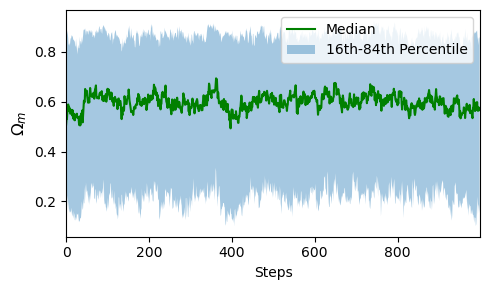

<IPython.core.display.Latex object>

In [27]:
# Extract the MCMC samples and remove the burn-in phase
burn_in_steps_lcdm = 1  # Set this if you want to remove some steps as burn-in

#mcmc_samples_lcdm = sampler_lcdm.get_chain(flat=True)[burn_in_steps_lcdm * n_walkers:]
samples_lcdm_collett=np.load('mcmc_samples_LCDM_collett_new_z_s2.npy')

#mcmc_samples_lcdm = sampler_lcdm.get_chain(flat=True)[burn_in_steps_lcdm * n_walkers:]
mcmc_samples_lcdm_collett=samples_lcdm_collett[burn_in_steps_lcdm * n_walkers:]
mcmc_samples_lcdm_collett_3d = samples_lcdm_collett.reshape((n_steps_mcmc, n_walkers, -1))


# Check if there are any samples
if mcmc_samples_lcdm_collett.size > 0:
    # Determine the number of parameters and steps
    n_params = 1  # Since n_params is fixed to 1
    chain = mcmc_samples_lcdm_collett_3d #sampler_lcdm_collett.get_chain()  # Shape: (n_steps_mcmc, n_walkers, n_params)
    chain = chain[burn_in_steps_lcdm:]  # Discard burn-in if any
    n_steps = chain.shape[0]

    # Initialize arrays to store statistics
    mean_pos = np.zeros((n_steps,))
    median_pos = np.zeros((n_steps,))
    std_pos = np.zeros((n_steps,))
    q16_pos = np.zeros((n_steps,))
    q84_pos = np.zeros((n_steps,))

    # Calculate statistics for the parameter at each step
    for j in range(n_steps):
        mean_pos[j] = np.mean(chain[j, :, 0])
        median_pos[j] = np.median(chain[j, :, 0])
        std_pos[j] = np.std(chain[j, :, 0])
        q16_pos[j] = np.percentile(chain[j, :, 0], 16.)
        q84_pos[j] = np.percentile(chain[j, :, 0], 84.)

    # Plotting the chain with median, and 16th-84th percentiles
    fig, ax = plt.subplots(figsize=(12, 6))  # Only one parameter, so no subplots
    param_name = r"$\Omega_m$"  # Adjust this if you have a different parameter

    ax.plot(median_pos, c='g', label='Median')
    ax.fill_between(np.arange(n_steps), q16_pos, q84_pos, alpha=0.4, label='16th-84th Percentile')
    ax.set_ylabel(param_name, fontsize=12)
    ax.legend()

    ax.set_xlim(0, n_steps)
    ax.set_xlabel('Steps')
    fig.set_size_inches((5, 3))  # Adjust the figure size for one parameter
    plt.tight_layout()
    plt.show()

# Calculate median values and uncertainties
median_Omega_m_lcdm_collett = np.median(mcmc_samples_lcdm_collett)
lower_Omega_m_lcdm_collett, upper_Omega_m_lcdm_collett = np.percentile(mcmc_samples_lcdm_collett, [16, 84])

# Display the median values with uncertainties
display(Latex(f'Median values: $\Omega_m = {median_Omega_m_lcdm_collett:.3f}_{{-{median_Omega_m_lcdm_collett - lower_Omega_m_lcdm_collett:.3f}}}^{{+{upper_Omega_m_lcdm_collett - median_Omega_m_lcdm_collett:.3f}}}$'))


#### 2D Distribution for Jackpot lens

plotting Jackpot lens constraints
Removed no burn in


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

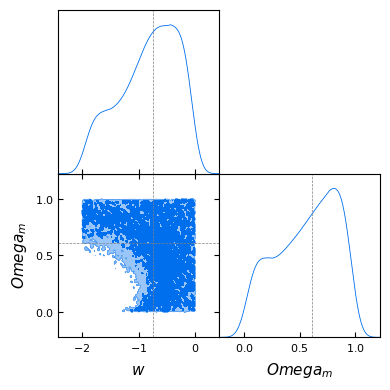

In [28]:
# Triangle plot using GetDist
print('plotting Jackpot lens constraints')
param_names = ['w', 'omega_m']

gdsamples = MCSamples(samples=mcmc_samples_collett, names=param_names,labels=['w', 'Omega_m']) #, labels=[r"$w$", r"$\Omega_m$"] ,labels=['w', 'Omega_m']

g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))
range_limits = {'w': [-2.0, 0], 'omega_m': [0., 1]}  # Modify these ranges as needed

g.triangle_plot([gdsamples], filled=True, 
                markers={'w': median_w0_model_collett, 'omega_m': median_Omega_m_model_collett},
                contour_args={'alpha': 1.},
                limits=range_limits
               )  # Apply range limits here

plt.close(fig)

# Display the median values with uncertainties
display(Latex(f'Median values: $\Omega_m = {median_Omega_m_model_collett:.3f}_{{-{median_Omega_m_model_collett - lower_Omega_m_collett:.3f}}}^{{+{upper_Omega_m_collett - median_Omega_m_model_collett:.3f}}}$'))
display(Latex(f'Median values: $w = {median_w0_model_collett:.3f}_{{-{median_w0_model_collett - lower_w0:.3f}}}^{{+{upper_w0_collett - median_w0_model_collett:.3f}}}$'))

# Joint constraints by combining constraints from independent studies

#### Probability Distribution Function (PDF) of Omega_m for LambdaCDM case (individual and joint distribution)

<IPython.core.display.Latex object>

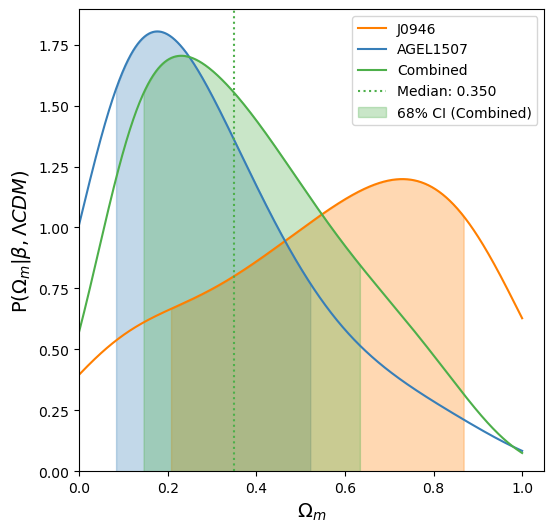

In [29]:
n_samples = len(mcmc_samples_lcdm)
if n_samples > 5000:
    mcmc_samples_lcdm_kde = np.random.choice(mcmc_samples_lcdm.flatten(), 5000, replace=False)

    
n_samples2 = len(mcmc_samples_lcdm_collett)
if n_samples > 5000:
    mcmc_samples_lcdm_collett_kde = np.random.choice(mcmc_samples_lcdm_collett.flatten(), 5000, replace=False)

# Generate data from two normal distributions
data1 = mcmc_samples_lcdm_kde #np.random.normal(0.33, 0.26, 1000)  # First distribution
num =len(mcmc_samples_lcdm_kde)
#data1=np.random.normal(0.337, 0.33, num) 
data2 = mcmc_samples_lcdm_collett_kde #np.random.normal(0.33, 0.26, 1000)  # 2sigma=2*0.26

# Create Kernel Density Estimates for both datasets
kde1 = gaussian_kde(data1, bw_method=0.5)
kde2 = gaussian_kde(data2,  bw_method=0.5)

# X values for which to evaluate the PDFs
x_vals = np.linspace(min(data1.min(), data2.min()), max(data1.max(), data2.max()), 1000)

# Evaluate the KDEs (PDFs) for both datasets
pdf1 = kde1(x_vals)
pdf2 = kde2(x_vals)

# Combine PDFs by multiplying them pointwise
pdf_combined = pdf1 * pdf2

# Normalize the combined PDF to ensure it integrates to 1
normalization_factor = np.trapz(pdf_combined, x_vals)  # Trapezoidal integration
pdf_combined /= normalization_factor

# Calculate the cumulative distribution function (CDF) for each PDF
cdf1 = np.cumsum(pdf1) * np.diff(x_vals)[0]  # CDF for PDF 1
cdf2 = np.cumsum(pdf2) * np.diff(x_vals)[0]  # CDF for PDF 2
cdf_combined = np.cumsum(pdf_combined) * np.diff(x_vals)[0]  # CDF for combined PDF


# Find the 68% confidence interval (16th to 84th percentile)
conf_68_low_1, conf_68_high_1 = np.percentile(data1, [16, 84])  # 68% CI for PDF 1
conf_68_low_2, conf_68_high_2 = np.percentile(data2, [16, 84])  # 68% CI for PDF 2
# Find the 68% confidence interval for the combined PDF
cdf_comb_values = np.interp([0.16, 0.84], cdf_combined, x_vals)  # Inverse CDF for combined PDF
conf_68_low_combined, conf_68_high_combined = cdf_comb_values  # 68% CI for combined PDF

# Find the median value (where CDF = 0.5)
#median_Om_data1= np.interp(0.5, cdf1, x_vals) 
#e_conf_68_low_1=median_Om_data1-conf_68_low_1
#e_conf_68_high_1=conf_68_high_1-median_Om_data1
#print(f"Median value from data1 PDF: {median_Om_data1}")
#display(Latex(f'Data1 Median values and 16 to 84 percentile (68%) : $\Omega_m = {median_Om_data1:.3f}_{{-{e_conf_68_low_1:.3f}}}^{{+{e_conf_68_high_1:.3f}}}$'))

#median_Om_data2= np.interp(0.5, cdf2, x_vals) 
#e_conf_68_low_2=median_Om_data2-conf_68_low_2
#e_conf_68_high_2=conf_68_high_2-median_Om_data2
#print(f"Median value from data2 PDF: {median_Om_data2}")
#display(Latex(f'Data2 Median values and 16 to 84 percentile (68%) : $\Omega_m = {median_Om_data2:.3f}_{{-{e_conf_68_low_2:.3f}}}^{{+{e_conf_68_high_2:.3f}}}$'))

median_combined_Om = np.interp(0.5, cdf_combined, x_vals)  # Interpolate to find the median
e_conf_68_low_combined=median_combined_Om-conf_68_low_combined
e_conf_68_high_combined=conf_68_high_combined-median_combined_Om

display(Latex(f'Combined Median values and 16 to 84 percentile (68%) : $\Omega_m = {median_combined_Om:.3f}_{{-{e_conf_68_low_combined:.3f}}}^{{+{e_conf_68_high_combined:.3f}}}$'))


# Plot the original and combined PDFs
plt.figure(figsize=(6, 6))

# Plot each individual PDF
plt.plot(x_vals, pdf2, label='J0946', color='#ff7f00')
plt.plot(x_vals, pdf1, label='AGEL1507', color='#377eb8') #DCLS1507 AGEL1507


# Plot the combined PDF
plt.plot(x_vals, pdf_combined, label='Combined', color='#4daf4a')

plt.axvline(x=median_combined_Om, color='#4daf4a',linestyle='dotted',label=f'Median: {median_combined_Om:.3f}')
#plt.axvline(x=median_Omega_m_lcdm, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_Omega_m_lcdm:.3f}')


# Fill the 68% confidence interval under each PDF
plt.fill_between(x_vals, pdf1, where=(x_vals >= conf_68_low_1) & (x_vals <= conf_68_high_1), 
                 color=CB_color_cycle['blue'], alpha=0.3, label=None) #'68% CI (This work)'
plt.fill_between(x_vals, pdf2, where=(x_vals >= conf_68_low_2) & (x_vals <= conf_68_high_2), 
                 color=CB_color_cycle['orange'], alpha=0.3, label=None) #'68% CI (Collett+14)'

# Fill the 68% confidence interval for the combined PDF
plt.fill_between(x_vals, pdf_combined, where=(x_vals >= conf_68_low_combined) & (x_vals <= conf_68_high_combined),
                 color=CB_color_cycle['green'], alpha=0.3, label='68% CI (Combined)')

# Add labels

# Add labels
plt.xlabel(r"$\Omega_m$",fontsize=14)
plt.ylabel(r"P$(\Omega_m | \beta, \Lambda CDM)$",fontsize=14)

# Adjust axis limits
plt.xlim(left=0)  # Ensure x-axis starts at 0
plt.ylim(bottom=0)  # Ensure y-axis starts at 0

# Add legend
plt.legend()

#plt.savefig( f'{savefig_path}/Om_PDF_LCDM_combined_J09_new_z2_1.pdf',  dpi=1200)

# Show the plot
plt.show()


### Plotting 2D distributions for all lenses together

Removed no burn in
Removed no burn in


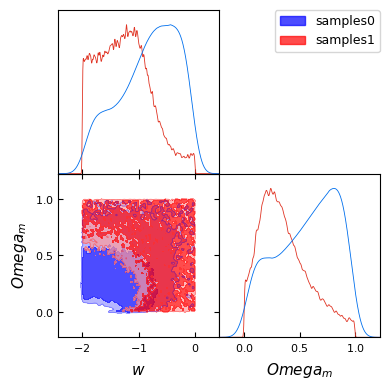

In [30]:
# Parameter names
param_names = ['w', 'omega_m']

# First set of samples
gdsamples1 = MCSamples(samples=samples, names=param_names, labels=['w', 'Omega_m'])

# Second set of samples (assuming another set of MCMC samples)
gdsamples2 = MCSamples(samples=mcmc_samples_collett, names=param_names, labels=['w', 'Omega_m'])


# GetDist plotter
g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))

# Define the range limits for the parameters
range_limits = {'w': [-2.0, 0], 'omega_m': [0., 1]}  # Adjust ranges as needed

# Plot the triangle plot with both MCMC samples
g.triangle_plot([gdsamples1, gdsamples2], filled=True, 
                contour_args={'alpha': 0.7,  'smooth': 1}, #{'alpha': 1.}, #'levels': 3,
                #param_pair=['w', 'omega_m'],  # Only plot the 2D distribution
                #labels=['Sample Set 1', 'Sample Set 2'],
                limits=range_limits,
                colors=['blue', 'red'],
               #labels_labels=None,
                legend_loc=None)


#plt.savefig( f'{savefig_path}/wLCDM_DSPL_J09_new_zs2.pdf',  dpi=1200)
plt.close(fig)


Removed no burn in
Removed no burn in


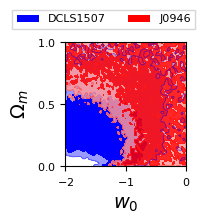

In [31]:
samples_dcls1507 = np.load('mcmc_samples_wCDM_DCLS1507_from_scratch_composite_double_source_11_run_07.npy')
#samples_J0946=np.load('mcmc_samples_collett_wCDM.npy')
samples_J0946=np.load('mcmc_samples_collett_wCDM_new_z_s2.npy')

# Parameter names and LaTeX labels
param_names = ['w', 'omega_m']
param_labels =[r"$w$", r"$\Omega_m$"]  # LaTeX labels
# First set of samples
gdsamples1 = MCSamples(samples=samples_dcls1507[:], names=param_names, labels=None) #labels=['w', 'omega_m']

# Second set of samples
gdsamples2 = MCSamples(samples=samples_J0946[:], names=param_names, labels=None)

# GetDist plotter
g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))

#legend_labels = ['Dataset 1', 'Dataset 2']
# Plot only the 2D distribution with filled contours for both datasets
g.plot_2d([gdsamples1, gdsamples2 ], param1='w', param2='omega_m', filled=True, 
          fine_bins=10, 
          colors=['blue', 'red'],
          apha=0.5,
          #legend_labels=legend_labels 
         )

# Optionally, apply limits

range_limits = {'w': [-2.0, 0], 'omega_m': [0., 1]}  # Adjust ranges as needed
g.set_axes( param_limits=range_limits) #[gdsamples1, gdsamples2],


ax = plt.gca()  # Get the current axes

# Manually set the axes limits if needed
plt.xlim(range_limits['w'])
plt.ylim(range_limits['omega_m'])

# Set axes labels
ax.set_xlabel(r"$w_0$", fontsize=14)  # X-axis label
ax.set_ylabel(r"$\Omega_m$", fontsize=14)  # Y-axis label


# Add custom legend for red and blue
legend_elements = [
    Patch(facecolor='blue', label='DCLS1507'), #edgecolor='black'
    Patch(facecolor='red',  label='J0946') #edgecolor='black'
]

# Add the legend to the plot
ax.legend(handles=legend_elements, bbox_to_anchor=(1.12, 1.3), fancybox=False, shadow=False, ncol=2, fontsize=8)

#plt.savefig( f'{savefig_path}/wLCDM_dspls.pdf',  dpi=1200)
plt.close(fig)

### Planck CMB data (from Anowar Shajib)

In [32]:

planck = None

for i in range(1, 5):
    if planck is None:
        planck = np.loadtxt(f"planck_chain/base_w_plikHM_TT_lowl_lowE_{i}.txt")
    else:
        planck = np.vstack(
            (planck, np.loadtxt(f"planck_chain/base_w_plikHM_TT_lowl_lowE_{i}.txt"))
        )

# planck = np.loadtxt("data/fwcdm_planck.txt", )

print(planck.shape)

planck_slice = planck[:, [26, 6]]
# planck_slice = planck[:, [1, 7]]

params = [r"$w$", r"$\Omega_\text{m}$"]

planck_df = DataFrame(planck_slice, columns=params)

planck_slice.shape

(40188, 90)


(40188, 2)

### Plotting all different observations together

Removed no burn in


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

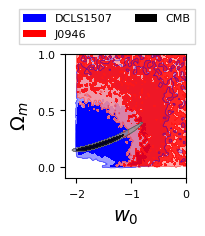

In [33]:
swapped_planck_slice = planck_slice[:, [1, 0]]
gdsamples3 = MCSamples(samples=swapped_planck_slice[:], names=param_names, labels=None)

median_w0_planck = np.median(swapped_planck_slice[:, 0])
lower_w0_planck, upper_w0_planck = np.percentile(swapped_planck_slice[:, 0], [16, 84])
median_Omega_m_planck = np.median(swapped_planck_slice[:, 1])
lower_Omega_m_planck, upper_Omega_m_planck= np.percentile(swapped_planck_slice[:, 1], [16, 84])

#Display the median values with uncertainties
display(Latex(f'Planck Median values  : $w = {median_w0_planck:.3f}_{{-{median_w0_planck - lower_w0_planck:.3f}}}^{{+{upper_w0_planck - median_w0_planck:.3f}}}$'))
display(Latex(f'Planck Median values: $\Omega_m = {median_Omega_m_planck:.3f}_{{-{median_Omega_m_planck - lower_Omega_m_planck:.3f}}}^{{+{upper_Omega_m_planck - median_Omega_m_planck:.3f}}}$'))


# GetDist plotter
g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))

g.plot_2d([gdsamples1, gdsamples2, gdsamples3 ], param1='w', param2='omega_m', filled=True, 
          fine_bins=10, 
          colors=['blue', 'red', 'black'],
          alpha=0.5,
          #legend_labels=legend_labels 
         )


range_limits = {'w': [-2.2, 0], 'omega_m': [-0.1, 1.0]}  # Adjust ranges as needed
g.set_axes( param_limits=range_limits) #[gdsamples1, gdsamples2],


ax = plt.gca()  # Get the current axes
#ax.add_patch(ellipse)

# Manually set the axes limits if needed
plt.xlim(range_limits['w'])
plt.ylim(range_limits['omega_m'])

# Set axes labels
ax.set_xlabel(r"$w_0$", fontsize=14)  # X-axis label
ax.set_ylabel(r"$\Omega_m$", fontsize=14)  # Y-axis label


# Add custom legend for red and blue
legend_elements = [
    Patch(facecolor='blue', label='DCLS1507'), #edgecolor='black'
    Patch(facecolor='red',  label='J0946'), #edgecolor='black'
    Patch(facecolor='black',  label='CMB')
]

# Add the legend to the plot
ax.legend(handles=legend_elements, bbox_to_anchor=(1.12, 1.4), fancybox=False, shadow=False, ncol=2, fontsize=8)

#plt.savefig( f'{savefig_path}/wLCDM_dspl_planck.pdf',  dpi=1200)
plt.close(fig)


## Combined constraint values

### combining constraints from gravitational lenses

Median: [-0.96969697  0.27272727]


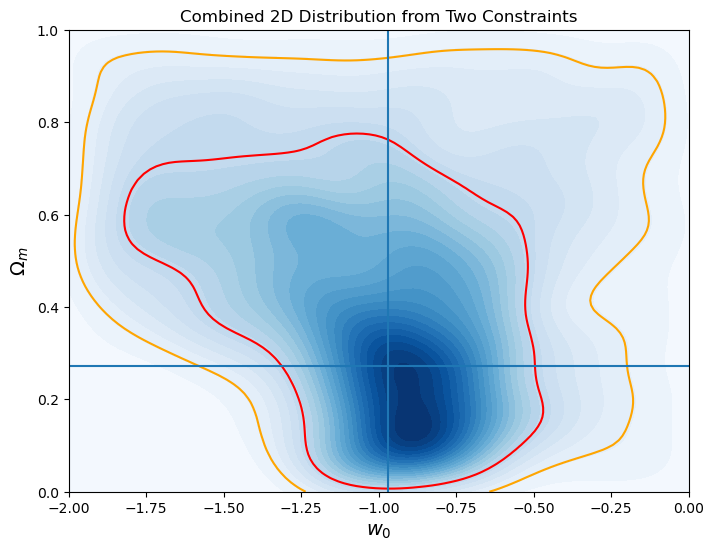

In [34]:


np.random.seed(0)  # For reproducibility
num_samples = 5000  # Adjust based on computational needs
mcmc_samples_wcdm_kde = samples_dcls1507[np.random.choice(samples_dcls1507.shape[0], num_samples, replace=False)]
mcmc_samples_wcdm_collett_kde = samples_J0946[np.random.choice(samples_J0946.shape[0], num_samples, replace=False)]

#Generate KDEs for both distributions
kde1_dcls1507 = gaussian_kde(mcmc_samples_wcdm_kde.T)
kde2_J0946 = gaussian_kde(mcmc_samples_wcdm_collett_kde.T)
#kde3 = gaussian_kde(mcmc_samples_wcdm_planck_kde.T)

# Define a grid over which to evaluate the combined distribution
x_grid, y_grid = np.mgrid[-2.0:0:100j, 0.0:1:100j ]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Combine the distributions (multiply the KDEs)
combined_density = kde1_dcls1507(positions) * kde2_J0946(positions)

combined_density = combined_density.reshape(x_grid.shape)


# Sort the density values to determine the confidence levels
sorted_density = np.sort(combined_density.ravel())[::-1] #sorted density in decensing order
cumulative_density = np.cumsum(sorted_density) / np.sum(sorted_density)

# Find density thresholds for the desired confidence levels (1, 2, and 3 sigma)
cof_levels = [
    #sorted_density[np.searchsorted(cumulative_density, 0.9973)],  # 3-sigma
    sorted_density[np.searchsorted(cumulative_density, 0.9545)],  # 2-sigma
    sorted_density[np.searchsorted(cumulative_density, 0.6827)],  # 1-sigma
]

# Calculate the total probability density
total_density = np.sum(combined_density)

# Calculate the CDF
cdf = np.cumsum(combined_density.ravel())
cdf /= cdf[-1]  # Normalize the CDF

# Find the median (50th percentile)
median_index = np.searchsorted(cdf, 0.5)
median = positions[:, median_index]
print("Median:", median)

# Plot the combined 2D distribution
plt.figure(figsize=(8, 6))
plt.contourf(x_grid, y_grid, combined_density, levels=30, cmap='Blues')
contours = plt.contour(x_grid, y_grid, combined_density, levels=cof_levels, colors=[ 'orange', 'red']) #'yellow',
#plt.clabel(contours, inline=True, fontsize=8, fmt={level: f"{sigma}-sigma" for sigma, level in zip([3, 2, 1], levels)})
#plt.colorbar(label='Density')
plt.axvline(median[0])
plt.axhline(median[1])
plt.title("Combined 2D Distribution from Two Constraints")
plt.xlabel(r"$w_0$", fontsize=14)
plt.ylabel(r"$\Omega_m$", fontsize=14)
#ax.set_xlabel(r"$w_0$", fontsize=14)  # X-axis label
#ax.set_ylabel(r"$\Omega_m$", fontsize=14)  # Y-axis label

plt.show()

### combined constraints values

In [35]:
#cumulative_density is based on combined density sorted in descending order. 
#while CDF is not sorted maintains the original order
#use cumulative_density for 68% bounds

# Find the density thresholds that correspond to the 68% confidence level
threshold_density = sorted_density[np.searchsorted(cumulative_density, 0.6827)] #cdf
print(threshold_density)
#print(cof_levels)
# Flatten combined_density and positions
flattened_density = combined_density.ravel()  # This creates a 1D array
flattened_positions = positions.T  # Transpose to get a shape of (n, 2) where n is the number of grid points

# Create a mask for samples above the threshold
within_bounds_mask = flattened_density >= threshold_density

# Check the mask to see if it is properly constructed
print("Within Bounds Mask Shape:", within_bounds_mask.shape)  # Should be (n,)
print("Number of samples within bounds:", np.sum(within_bounds_mask))

# Extract filtered samples based on the mask
filtered_samples = flattened_positions[within_bounds_mask]

# Check the shape of the filtered samples
print("Filtered Samples Shape:", filtered_samples.shape)  # Should be (m, 2) where m is the number of filtered samples

# Separate into w_0 and Ω_m
w_0_samples = filtered_samples[:, 0]  # First column corresponds to w_0
Omega_m_samples = filtered_samples[:, 1]  # Second column corresponds to Ω_m

#print("Filtered w_0 Samples:", w_0_samples)
#print("Filtered Ω_m Samples:", Omega_m_samples)

# Find the median (50th percentile).
#Use CDF for median calculation, becasue cumulative distribution functions (CDFs) preserve the original order of density values.
#the original order is important for calculating median that divides the distribiution into two halfs

median_index = np.searchsorted(cdf, 0.5)
median_dspl = positions[:, median_index]  # [w_0, Omega_m]

# Print the median results
print("Median values (w_0, Omega_m):", median_dspl)
median_dspl_w0=median_dspl[0]
median_dspl_Omega_m=median_dspl[1]

# Calculate and print the bounds for the filtered samples
lower_bound_w0 = np.min(w_0_samples)
upper_bound_w0 = np.max(w_0_samples)

lower_bound_Omega_m = np.min(Omega_m_samples)
upper_bound_Omega_m = np.max(Omega_m_samples)
#
print("68% Confidence Bound for w_0: [{:.4f}, {:.4f}]".format(lower_bound_w0, upper_bound_w0))
print("68% Confidence Bound for Ω_m: [{:.4f}, {:.4f}]".format(lower_bound_Omega_m, upper_bound_Omega_m))

# Display the median values with uncertainties
display(Latex(f'Median values: $w = {median_dspl_w0:.3f}_{{-{median_dspl_w0 - lower_bound_w0:.3f}}}^{{+{upper_bound_w0 - median_dspl_w0:.3f}}}$'))
display(Latex(f'Median values: $\Omega_m = {median_dspl_Omega_m:.3f}_{{-{median_dspl_Omega_m - lower_bound_Omega_m:.3f}}}^{{+{upper_bound_Omega_m - median_dspl_Omega_m:.3f}}}$'))


0.1659933159485187
Within Bounds Mask Shape: (10000,)
Number of samples within bounds: 3324
Filtered Samples Shape: (3324, 2)
Median values (w_0, Omega_m): [-0.96969697  0.27272727]
68% Confidence Bound for w_0: [-1.8182, -0.4848]
68% Confidence Bound for Ω_m: [0.0101, 0.7677]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [36]:
#obtaining parameters with maximum combined probability
max_index = np.argmax(combined_density.ravel())  # Find index of maximum
print(max_index)
max_dens_parameters=positions[:,max_index]
print(max_dens_parameters)

5514
[-0.88888889  0.14141414]


### Plotting combined constraint

plotting combined DSPLs constraints
Removed no burn in


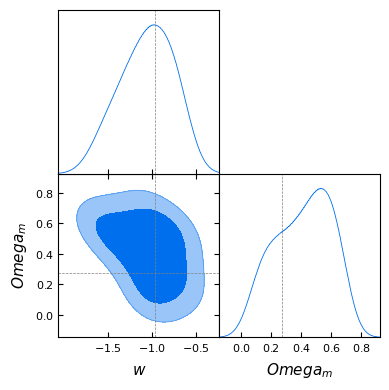

In [45]:
# Triangle plot using GetDist
print('plotting combined DSPLs constraints')
param_names = ['w', 'omega_m']

gdsamples_dcls = MCSamples(samples=filtered_samples, names=param_names,labels=['w', 'Omega_m']) #, labels=[r"$w$", r"$\Omega_m$"] ,labels=['w', 'Omega_m']

g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))
range_limits = {'w': [-2.0, 0], 'omega_m': [0., 1]}  # Modify these ranges as needed

g.triangle_plot([gdsamples_dcls], filled=True, 
                markers={'w': median_dspl[0], 'omega_m': median_dspl[1]},
                contour_args={'alpha': 1.},
                limits=range_limits
               )  # Apply range limits here

plt.close(fig)

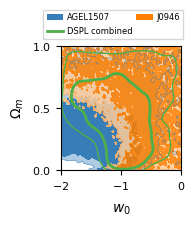

In [46]:
#gdsamples3 = MCSamples(samples=swapped_planck_slice[:], names=param_names, labels=None)

# GetDist plotter
g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))

g.plot_2d([gdsamples1, gdsamples2 ], param1='w', param2='omega_m', filled=True, 
          fine_bins=10, 
          colors=['#377eb8', '#ff7f00'], 
          alpha=0.5,
          #legend_labels=legend_labels 
         )


range_limits = {'w': [-2.0, 0.0], 'omega_m': [0.0, 1.0]}  # Adjust ranges as needed
g.set_axes( param_limits=range_limits) #[gdsamples1, gdsamples2],


ax = plt.gca()  # Get the current axes

# Manually set the axes limits if needed
plt.xlim(range_limits['w'])
plt.ylim(range_limits['omega_m'])
#plt.contourf(x_grid, y_grid, combined_density, levels=3, cmap='Greens')
contours = plt.contour(x_grid, y_grid, combined_density, levels=cof_levels, colors=[ '#4daf4a', '#4daf4a'], linewidths=[1, 2]) #'yellow',
#plt.clabel(contours, inline=True, fontsize=8, fmt={level: f"{sigma}-sigma" for sigma, level in zip([3, 2, 1], levels)})
#plt.colorbar(label='Density')

# Set axes labels
ax.set_xlabel(r"$w_0$", fontsize=10)  # X-axis label
ax.set_ylabel(r"$\Omega_m$", fontsize=10)  # Y-axis label


# Add custom legend for red and blue
legend_elements = [
    Patch(facecolor='#377eb8', label='AGEL1507'), #edgecolor='black' DCLS1507
    #Line2D([0], [0], color='#377eb8', lw=2, label='AGEL1507'),
     Line2D([0], [0], color='#4daf4a', lw=2, label='DSPL combined'),
    Patch(facecolor='#ff7f00',  label='J0946'), #edgecolor='black'
   #Line2D([0], [0], color='#ff7f00', lw=2, label='J0946')
   
]


ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.32), fancybox=False, shadow=False,
          ncol=2, fontsize=6, handletextpad=0.4, columnspacing=0.5) #(1.12, 1.35)


#plt.savefig( f'{savefig_path}/wLCDM_DSPL_combined_J09_new_zs2_2.pdf',  dpi=1200)
plt.close(fig)

### Plotting CMB Planck CMB constraint over combined lensing constraints

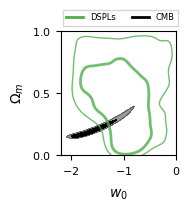

In [47]:

#gdsamples3 = MCSamples(samples=swapped_planck_slice[:], names=param_names, labels=None)

# GetDist plotter
g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))

g.plot_2d([gdsamples3 ], param1='w', param2='omega_m', filled=True, 
          fine_bins=10, 
          colors=['black'], #CB_color_cycle['brown']
          alpha=1,
          #legend_labels=legend_labels 
         )


range_limits = {'w': [-2.2, 0], 'omega_m': [0, 1.0]}  # Adjust ranges as needed
g.set_axes( param_limits=range_limits) #[gdsamples1, gdsamples2],


ax = plt.gca()  # Get the current axes
#ax.add_patch(ellipse)

# Manually set the axes limits if needed
plt.xlim(range_limits['w'])
plt.ylim(range_limits['omega_m'])
#plt.contourf(x_grid, y_grid, combined_density, levels=30,colors=['lightgreen'], alpha=0.5 ) #cmap='Greens'
contours = plt.contour(x_grid, y_grid, combined_density, levels=cof_levels, colors=[ '#4daf4a', '#4daf4a'], linewidths=[1, 2],alpha=0.8) #'yellow',
#plt.clabel(contours, inline=True, fontsize=8, fmt={level: f"{sigma}-sigma" for sigma, level in zip([3, 2, 1], levels)})
#plt.colorbar(label='Density')

# Set axes labels
ax.set_xlabel(r"$w_0$", fontsize=10)  # X-axis label
ax.set_ylabel(r"$\Omega_m$", fontsize=10)  # Y-axis label


# Add custom legend for red and blue
legend_elements = [
    #Patch(facecolor='blue', label='DCLS1507'), #edgecolor='black'
    #Patch(facecolor='red',  label='J0946'), #edgecolor='black'
    Line2D([0], [0], color='#4daf4a', lw=2, label='DSPLs'),
    Line2D([0], [0], color='black', lw=2, label='CMB'), #CB_color_cycle['brown']
   
]

# Add the legend to the plot
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.2), fancybox=False, shadow=False, ncol=2, fontsize=6)

#plt.savefig( f'{savefig_path}/wLCDM_CMB_plus_DSPL_J09_new_zs2.pdf',  dpi=1200)
plt.close(fig)

### Joint constraints from Lensing and other Studies (CMB, ...)

In [48]:
mcmc_samples_wcdm_Planck_kde = swapped_planck_slice[np.random.choice(swapped_planck_slice.shape[0], num_samples, replace=False)]

kde3_Planck = gaussian_kde(mcmc_samples_wcdm_Planck_kde.T)
# Define a grid over which to evaluate the combined distribution
combined_density_DSPLs_Planck = kde1_dcls1507(positions) * kde2_J0946(positions) * kde3_Planck(positions)
combined_density_DSPLs_Planck = combined_density_DSPLs_Planck.reshape(x_grid.shape)

# Sort the density values to determine the confidence levels
sorted_density_DSPLs_Planck = np.sort(combined_density_DSPLs_Planck.ravel())[::-1]
cumulative_density_DSPLs_Planck = np.cumsum(sorted_density_DSPLs_Planck) / np.sum(sorted_density_DSPLs_Planck)

# Find density thresholds for the desired confidence levels (1, 2, and 3 sigma)
levels_DSPLs_Planck = [
    #sorted_density_DSPLs_Planck[np.searchsorted(cumulative_density_DSPLs_Planck, 0.9973)],  # 3-sigma
    sorted_density_DSPLs_Planck[np.searchsorted(cumulative_density_DSPLs_Planck, 0.9545)],  # 2-sigma
    sorted_density_DSPLs_Planck[np.searchsorted(cumulative_density_DSPLs_Planck, 0.6827)],  # 1-sigma
]

In [49]:
#cumulative_density is based on combined density sorted in descending order. 
#while CDF is not sorted maintains the original order
#use cumulative_density for 68% bounds

# Find the density thresholds that correspond to the 68% confidence level
threshold_density_DSPLs_Planck = sorted_density_DSPLs_Planck[np.searchsorted(cumulative_density_DSPLs_Planck, 0.6827)] #cdf
print(threshold_density_DSPLs_Planck)
#print(cof_levels)
# Flatten combined_density and positions
flattened_density_DSPLs_Planck = combined_density_DSPLs_Planck.ravel()  # This creates a 1D array
flattened_positions_DSPLs_Planck = positions.T  # Transpose to get a shape of (n, 2) where n is the number of grid points

# Create a mask for samples above the threshold
within_bounds_mask_DSPLs_Planck = flattened_density_DSPLs_Planck >= threshold_density_DSPLs_Planck

# Check the mask to see if it is properly constructed
print("Within Bounds Mask Shape:", within_bounds_mask_DSPLs_Planck.shape)  # Should be (n,)
print("Number of samples within bounds:", np.sum(within_bounds_mask_DSPLs_Planck))

# Extract filtered samples based on the mask
filtered_samples_DSPLs_Planck = flattened_positions_DSPLs_Planck[within_bounds_mask_DSPLs_Planck]

# Check the shape of the filtered samples
print("Filtered Samples Shape:", filtered_samples_DSPLs_Planck.shape)  # Should be (m, 2) where m is the number of filtered samples

# Separate into w_0 and Ω_m
w_0_samples_DSPLs_Planck = filtered_samples_DSPLs_Planck[:, 0]  # First column corresponds to w_0
Omega_m_samples_DSPLs_Planck = filtered_samples_DSPLs_Planck[:, 1]  # Second column corresponds to Ω_m

#print("Filtered w_0 Samples:", w_0_samples)
#print("Filtered Ω_m Samples:", Omega_m_samples)

# Find the median (50th percentile).
#Use CDF for median calculation, becasue cumulative distribution functions (CDFs) preserve the original order of density values.
#the original order is important for calculating median that divides the distribiution into two halfs

# Calculate the CDF
cdf_DSPLs_Planck = np.cumsum(combined_density_DSPLs_Planck.ravel())
cdf_DSPLs_Planck /= cdf_DSPLs_Planck[-1]  # Normalize the CDF

median_index_DSPLs_Planck = np.searchsorted(cdf_DSPLs_Planck, 0.5)
median_DSPLs_Planck = positions[:, median_index_DSPLs_Planck]  # [w_0, Omega_m]

# Print the median results
print("Median values (w_0, Omega_m):", median_DSPLs_Planck)
median_DSPLs_Planck_w0=median_DSPLs_Planck[0]
median_DSPLs_Planck_Omega_m=median_DSPLs_Planck[1]

# Calculate and print the bounds for the filtered samples
DSPLs_Planck_lower_bound_w0 = np.min(w_0_samples_DSPLs_Planck)
DSPLs_Planck_upper_bound_w0 = np.max(w_0_samples_DSPLs_Planck)

DSPLs_Planck_lower_bound_Omega_m = np.min(Omega_m_samples_DSPLs_Planck)
DSPLs_Planck_upper_bound_Omega_m = np.max(Omega_m_samples_DSPLs_Planck)
#
print("68% Confidence Bound for w_0: [{:.4f}, {:.4f}]".format(DSPLs_Planck_lower_bound_w0, DSPLs_Planck_upper_bound_w0))
print("68% Confidence Bound for Ω_m: [{:.4f}, {:.4f}]".format(DSPLs_Planck_lower_bound_Omega_m, DSPLs_Planck_upper_bound_Omega_m))

# Display the median values with uncertainties
display(Latex(f'Median values: $w = {median_DSPLs_Planck_w0:.3f}_{{-{median_DSPLs_Planck_w0 - DSPLs_Planck_lower_bound_w0:.3f}}}^{{+{DSPLs_Planck_upper_bound_w0 - median_DSPLs_Planck_w0:.3f}}}$'))
display(Latex(f'Median values: $\Omega_m = {median_DSPLs_Planck_Omega_m:.3f}_{{-{median_DSPLs_Planck_Omega_m - DSPLs_Planck_lower_bound_Omega_m:.3f}}}^{{+{DSPLs_Planck_upper_bound_Omega_m - median_DSPLs_Planck_Omega_m:.3f}}}$'))


1.8519218367942891
Within Bounds Mask Shape: (10000,)
Number of samples within bounds: 95
Filtered Samples Shape: (95, 2)
Median values (w_0, Omega_m): [-1.11111111  0.27272727]
68% Confidence Bound for w_0: [-1.4343, -0.8889]
68% Confidence Bound for Ω_m: [0.2222, 0.3535]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

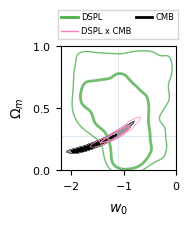

In [50]:
# GetDist plotter
g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))

g.plot_2d([gdsamples3 ], param1='w', param2='omega_m', filled=True, 
          fine_bins=10, 
          colors=['black'],  #
          alpha=1,
          #legend_labels=legend_labels 
         )


range_limits = {'w': [-2.2, 0], 'omega_m': [0, 1.0]}  # Adjust ranges as needed
g.set_axes( param_limits=range_limits) #[gdsamples1, gdsamples2],


ax = plt.gca()  # Get the current axes
#ax.add_patch(ellipse)

# Manually set the axes limits if needed
plt.xlim(range_limits['w'])
plt.ylim(range_limits['omega_m'])
#plt.contourf(x_grid, y_grid, combined_density, levels=30,colors=['lightgreen'], alpha=0.5 ) #cmap='Greens'
contours = plt.contour(x_grid, y_grid, combined_density, levels=cof_levels, colors=[ '#4daf4a', '#4daf4a'], linewidths=[1, 2],alpha=0.8) #'yellow',
#contours2 = plt.contour(x_grid, y_grid, combined_density_DSPLs_Planck, levels=levels, colors=[ '#f781bf', '#f781bf'], linewidths=[1, 2],alpha=0.8) #'yellow',
contours2 = plt.contour(x_grid, y_grid, combined_density_DSPLs_Planck, levels=levels_DSPLs_Planck, colors=[ CB_color_cycle['pink'], CB_color_cycle['pink']], linewidths=[0.5, 1],alpha=1) 

#plt.clabel(contours, inline=True, fontsize=8, fmt={level: f"{sigma}-sigma" for sigma, level in zip([3, 2, 1], levels)})
#plt.colorbar(label='Density')

plt.axvline(median_DSPLs_Planck[0],linewidth=0.5, alpha=0.2)
plt.axhline(median_DSPLs_Planck[1],linewidth=0.5, alpha=0.2)

# Set axes labels
ax.set_xlabel(r"$w_0$", fontsize=10)  # X-axis label
ax.set_ylabel(r"$\Omega_m$", fontsize=10)  # Y-axis label

# Add custom legend for red and blue
legend_elements = [
    Line2D([0], [0], color='#4daf4a', lw=2, label='DSPL'),
     Line2D([0], [0], color=CB_color_cycle['pink'], lw=1,  label='DSPL x CMB'),  # linestyle='--', #
    Line2D([0], [0], color='black', lw=2, label='CMB'), #CB_color_cycle['brown']
    #Patch(facecolor='black',  label='DSPLs x CMB',),
   
]

# Add the legend to the plot
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.32), fancybox=False, shadow=False,
          ncol=2, fontsize=6, handletextpad=0.4, columnspacing=0.5) #(1.12, 1.35)

#plt.savefig( f'{savefig_path}/wLCDM_CMB_DSPL_combined_J09_new_zs2_3.pdf',  dpi=1200)
plt.close(fig)

plotting combined DSPLs+CMB constraints
Removed no burn in


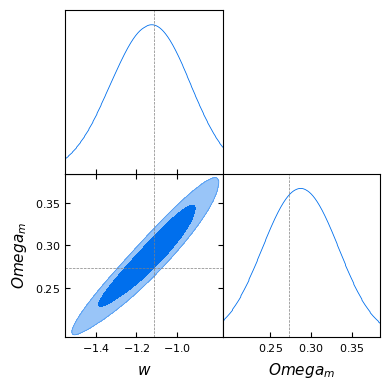

In [51]:
print('plotting combined DSPLs+CMB constraints')
param_names = ['w', 'omega_m']

gdsamples_dcls_CMB = MCSamples(samples=filtered_samples_DSPLs_Planck, names=param_names,labels=['w', 'Omega_m']) #, labels=[r"$w$", r"$\Omega_m$"] ,labels=['w', 'Omega_m']

g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))
range_limits = {'w': [-2.0, 0], 'omega_m': [0., 1]}  # Modify these ranges as needed

g.triangle_plot([gdsamples_dcls_CMB], filled=True, 
                markers={'w': median_DSPLs_Planck[0], 'omega_m': median_DSPLs_Planck[1]},
                contour_args={'alpha': 1.},
                limits=range_limits
               )  # Apply range limits here

plt.close(fig)